<a href="https://colab.research.google.com/github/rbarman/AnimeGANs/blob/master/Anime_face_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Inspiration from https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html

In [1]:
from IPython.display import Image as display_image
from google.colab import drive
import os
import random
import PIL
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.transforms as T
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid, save_image
from tqdm.notebook import tqdm
%matplotlib inline

In [2]:
!git clone https://github.com/rbarman/AnimeGANs

Cloning into 'AnimeGANs'...
remote: Enumerating objects: 48, done.
remote: Counting objects: 100% (48/48), done.
remote: Compressing objects: 100% (43/43), done.
remote: Total 48 (delta 19), reused 11 (delta 3), pack-reused 0
Unpacking objects: 100% (48/48), done.


In [3]:
%cd AnimeGANs/

/content/AnimeGANs


In [4]:
!ls

Anime_face_GAN.ipynb  device_utils.py  my_modules.py  README.md  train_utils.py


In [6]:
from my_modules import Discriminator, Generator
from device_utils import get_default_device, DeviceDataLoader, to_device
from train_utils import GANTrainer

**Get images**
- I saved results from https://github.com/bchao1/Anime-Face-Dataset to google drive
- Could get more samples using the haar cascade from https://github.com/nagadomi/animeface-2009

In [7]:
%%capture
drive.mount('/content/drive')
!tar -xvzf  /content/drive/My\ Drive/Anime-Faces.tgz

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········


In [8]:
def view_rand_img(img_dir = '/content/AnimeGANs/cropped/'):
  imgs = os.listdir(img_dir)
  img_path = img_dir  + random.choice(imgs)
  print(img_path)
  return display_image(img_path)

/content/AnimeGANs/cropped/29797_2010.jpg


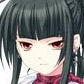

In [9]:
view_rand_img()

In [10]:
# There are some invalid images...
display_image('/content/AnimeGANs/cropped/44478_2013.jpg')

In [11]:
for img_name in os.listdir('/content/AnimeGANs/cropped/'):
  img_path = f'/content/AnimeGANs/cropped/{img_name}'
  try:
    _ = PIL.Image.open(img_path)
  except PIL.UnidentifiedImageError:
    #print(f'{img_path} is an invalid image')
    os.remove(img_path)

Create DataLoaders

In [12]:
ROOT_IMAGE_DIR = '/content/'
IMAGE_SIZE = 64
BATCH_SIZE = 128
LATENT_SIZE = 100
NUM_CHANNELS = 3
STATS = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [13]:
train_ds = ImageFolder(ROOT_IMAGE_DIR, transform=T.Compose([
    T.Resize(IMAGE_SIZE),
    T.CenterCrop(IMAGE_SIZE),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize(*STATS)]))

In [14]:
train_dl = DataLoader(train_ds, BATCH_SIZE, shuffle=True, num_workers=3)

In [15]:
def show_batch(dl):
  images, _ = next(iter(dl))
  plt.figure(figsize=(8,8))
  plt.axis("off")
  # permuting because matplotlib needs (x,y, num channels) while tensor is (num channels, x, y)
  plt.imshow(make_grid(images.detach()[0:64],padding=2,normalize=True,).permute(1,2,0));

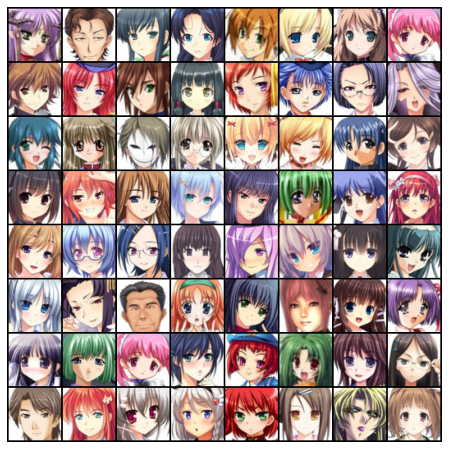

In [16]:
show_batch(train_dl)

In [17]:
device = get_default_device()
device

device(type='cuda')

In [18]:
train_dl = DeviceDataLoader(train_dl, device)

In [19]:
images,labels = next(iter(train_dl))
images.shape, labels.shape

(torch.Size([128, 3, 64, 64]), torch.Size([128]))

Confirm shapes with Discriminator and Generator

In [20]:
# Discriminator classifies if an image is real or not
  # input is a batch of images
  # output is a batch of results
discriminator = Discriminator(num_features = 64)
discriminator = to_device(discriminator, device)
images,labels = next(iter(train_dl))

print(f'INPUT: ',images.shape)
out = discriminator(images)
print('OUTPUT: ',out.shape)

INPUT:  torch.Size([128, 3, 64, 64])
OUTPUT:  torch.Size([128, 1])


In [21]:
# Generator takes a vector of noise and creates images
  # input is batch of noise/random 
  # output is a batch of images
generator = Generator(latent_vector_len = LATENT_SIZE,num_features = 64)
generator = to_device(generator, device)
noise = torch.randn(BATCH_SIZE, LATENT_SIZE, 1, 1, device=device)
print(f'INPUT: ',noise.shape)
out = generator(noise)
print('OUTPUT: ',out.shape)

INPUT:  torch.Size([128, 100, 1, 1])
OUTPUT:  torch.Size([128, 3, 64, 64])


Training Loop

In [ ]:
'''
pseudo code of training loop:

for epoch in epochs:
  for batch in train dataloader:
    
    # Train Discriminator
    - forward pass of {real} images to Discriminator
    - calculate loss + backwards pass

    - create batch of fake images from Generator
    - forward pass of images to Discriminator
    - calculate loss + backwards pass

    - add both gradients from both losses  + update Discriminator weights

    # Train Generator
    - foward pass of latent vector to create fake images
    - forward pass of fake images to Discriminator
    - calculate loss (how well the discrimator classifies the images are fake)
    - backwards pass + update weights
'''

'\npseudo code of training loop:\n\nfor epoch in epochs:\n  for batch in train dataloader:\n    \n    # Train Discriminator\n    - forward pass of {real} images to Discriminator\n    - calculate loss + backwards pass\n\n    - create batch of fake images from Generator\n    - forward pass of images to Discriminator\n    - calculate loss + backwards pass\n\n    - add both gradients from both losses  + update Discriminator weights\n\n    # Train Generator\n    - foward pass of latent vector to create fake images\n    - forward pass of fake images to Discriminator\n    - calculate loss (how well the discrimator classifies the images are fake)\n    - backwards pass + update weights\n'

In [ ]:
# images, _ = next(iter(train_dl))

# optimizerD = torch.optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
# train_discriminator(images)

In [ ]:
# optimizerG = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
# train_generator()

7.022176191640028e-07

In [22]:
gan = GANTrainer(train_dl)
history = gan.train(1)


Saving to /content/AnimeGANS/generated/1.png
Epoch [1/1], loss_g: 2.0414, loss_d: 1.2240, real_score: 0.3781, fake_score: 0.0183


Results per epoch

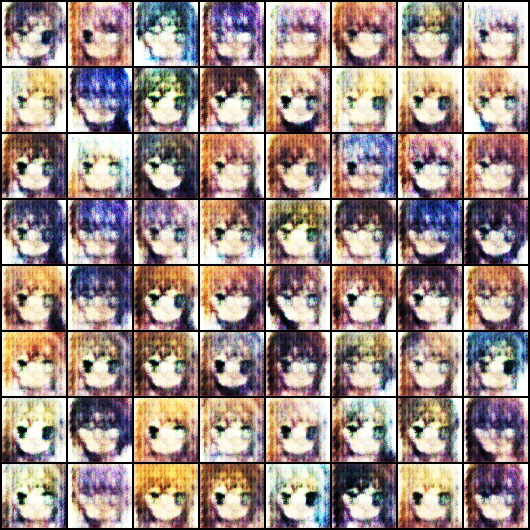

In [23]:
display_image('/content/AnimeGANS/generated/1.png')

Still needs more epochs... Generated images are still blurry